## Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset as HFDataset
import warnings
warnings.filterwarnings('ignore')


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import random
import os

def set_seed(seed=42):
    """
    Set seeds for reproducible results across different libraries
    """
    # Python random seed
    random.seed(seed)

    # NumPy random seed
    np.random.seed(seed)

    # PyTorch random seed
    torch.manual_seed(seed)

    # CUDA random seed (for GPU)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

        # Additional CUDA settings for reproducibility
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Environment variable for Python hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

# Usage
set_seed(42)

In [ ]:
def load_and_explore_data(file_path):
    """
    Load the dataset and perform initial exploration
    Expected format: CSV with columns 'sentence' and 'label'
    Labels should be: 'support', 'refute', 'not enough information'
    """

    # Load the dataset
    df = pd.read_csv(file_path)
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print("\nFirst few rows:")
    print(df.head())

    # Check for missing values
    print(f"\nMissing values:\n{df.isnull().sum()}")

    # Analyze class distribution
    class_counts = df['claims_labels'].value_counts()
    print(f"\nClass distribution:")
    print(class_counts)
    print(f"\nClass proportions:")
    print(df['claims_labels'].value_counts(normalize=True))

    # Visualize class distribution
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    class_counts.plot(kind='bar')
    plt.title('Class Distribution (Count)')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    df['claims_labels'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
    plt.title('Class Distribution (Percentage)')

    plt.tight_layout()
    plt.show()

    # Text length analysis
    df['text_length'] = df['claims'].str.len()
    df['word_count'] = df['claims'].str.split().str.len()

    print(f"\nText statistics:")
    print(df[['text_length', 'word_count']].describe())

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    df['text_length'].hist(bins=50, alpha=0.7)
    plt.title('Distribution of Text Length (characters)')
    plt.xlabel('Character count')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    df['word_count'].hist(bins=50, alpha=0.7)
    plt.title('Distribution of Word Count')
    plt.xlabel('Word count')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return df

In [ ]:
def check_class_imbalance(df, threshold=0.6):
    """
    Check if dataset has significant class imbalance
    """
    class_proportions = df['claims_labels'].value_counts(normalize=True)
    max_proportion = class_proportions.max()

    print(f"Maximum class proportion: {max_proportion:.3f}")

    if max_proportion > threshold:
        print(f"⚠️  Class imbalance detected! Majority class has {max_proportion:.1%} of samples")
        return True
    else:
        print("✅ Classes are relatively balanced")
        return False

In [ ]:
# data_file_path = 'cleaned_data_no_special_characters.csv'

In [ ]:
# df = load_and_explore_data(data_file_path)

In [ ]:
# from datasets import load_dataset
# import pandas as pd

# # 1. Load the dataset
# dataset = load_dataset("amandakonet/climate_fever_adopted")

# # 2. Convert to pandas DataFrames and keep only required columns
# train_df = pd.DataFrame(dataset['train'])[["claim", "evidence_label"]].rename(columns={"claim": "claims", "evidence_label": "claims_labels"})
# val_df = pd.DataFrame(dataset['valid'])[["claim", "evidence_label"]].rename(columns={"claim": "claims", "evidence_label": "claims_labels"})
# test_df = pd.DataFrame(dataset['test'])[["claim", "evidence_label"]].rename(columns={"claim": "claims", "evidence_label": "claims_labels"})

Repo card metadata block was not found. Setting CardData to empty.


In [ ]:
from datasets import load_dataset
import pandas as pd

# 1. Load the datasetJasontth/climate_fever_plus
dataset = load_dataset("Jasontth/climate_fever_plus")

# 2. Convert to pandas DataFrames and keep only required columns
train_df = pd.DataFrame(dataset['train'])[["claim", "evidence_label"]].rename(columns={"claim": "claims", "evidence_label": "claims_labels"})
val_df = pd.DataFrame(dataset['valid'])[["claim", "evidence_label"]].rename(columns={"claim": "claims", "evidence_label": "claims_labels"})
test_df = pd.DataFrame(dataset['test'])[["claim", "evidence_label"]].rename(columns={"claim": "claims", "evidence_label": "claims_labels"})

In [ ]:

def calculate_class_weights(df):
    """
    Calculate class weights for handling imbalance in loss function
    Uses sklearn's balanced approach: n_samples / (n_classes * np.bincount(y))
    """
    from sklearn.utils.class_weight import compute_class_weight

    # Get class distribution
    class_counts = df['claims_labels'].value_counts()
    print(f"Class distribution:\n{class_counts}")
    print(f"Class proportions:\n{df['claims_labels'].value_counts(normalize=True)}")

    # Calculate class weights
    labels = df['claims_labels'].values
    unique_labels = sorted(df['claims_labels'].unique())

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array(unique_labels),
        y=labels
    )

    # Create mapping
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    label_weight_dict = {label: class_weights[i] for i, label in enumerate(unique_labels)}

    print(f"\nCalculated class weights:")
    for label, weight in label_weight_dict.items():
        print(f"  {label}: {weight:.3f}")

    return class_weight_dict, label_weight_dict

Preprocessing

In [ ]:
# import re

# def basic_text_preprocessing(text):
#     text = text.strip()
#     # lowercase (skip if your model is cased)
#     text = text.lower()
#     # remove URLs
#     text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
#     # remove extra spaces
#     text = re.sub(r'\s+', ' ', text)
#     return text

# train_df['claims'] = train_df['claims'].apply(basic_text_preprocessing)


In [ ]:
print(train_df['claims'].head())

0    Satellite transmissions are extremely small an...
1    Scientists studying Antarctica sea ice warn a ...
2    The connection between the vanishing Arctic ic...
3    Seventeen of the 18 warmest years have occurre...
4    the first scientists to show that the thick ic...
Name: claims, dtype: object


Undersampling



1. Undersampling with the label support equal to the label not enough info did not work well we saw that F1 score for not enough info dropped and not much improvised for support or refute because there is still a class imbalance so majorly overall decreasing the accuracy
2. Now, undersampling with the count equal to the minority clause was extreme. Undersampling with 456 labels for every clause, there was a drastic decrease in accuracy, and yes, possibly due to lesser data and also a complete fine-tuning of a big model.
3. Like with conservative undersampling with like not enough info labels to be 1654, and the result wasn't good enough and rather it decreased than not doing any kind of undersampling.








In [ ]:
# from sklearn.utils import resample

# # Separate classes
# df_not_enough_info = train_df[train_df['claims_labels'] == 'NOT_ENOUGH_INFO']
# df_supports = train_df[train_df['claims_labels'] == 'SUPPORTS']
# df_refutes = train_df[train_df['claims_labels'] == 'REFUTES']

# # Find minority class size
# minority_size = max(len(df_supports), len(df_refutes))

# # Undersample majority class
# df_not_enough_info_downsampled = resample(
#     df_not_enough_info,
#     replace=False,
#     n_samples=minority_size,
#     random_state=42
# )

# # Combine and overwrite train_df
# train_df = pd.concat([df_not_enough_info_downsampled, df_supports, df_refutes]).reset_index(drop=True)

# print(train_df['claims_labels'].value_counts())


In [ ]:
# from sklearn.utils import resample

# # Separate classes
# df_not_enough_info = train_df[train_df['claims_labels'] == 'NOT_ENOUGH_INFO']
# df_supports = train_df[train_df['claims_labels'] == 'SUPPORTS']
# df_refutes = train_df[train_df['claims_labels'] == 'REFUTES']

# # Find true minority class size (smallest of all three)
# minority_size = min(len(df_not_enough_info), len(df_supports), len(df_refutes))

# # Undersample all classes to minority size
# df_not_enough_info_downsampled = resample(
#     df_not_enough_info,
#     replace=False,
#     n_samples=minority_size,
#     random_state=42
# )

# df_supports_downsampled = resample(
#     df_supports,
#     replace=False,
#     n_samples=minority_size,
#     random_state=42
# )

# df_refutes_downsampled = resample(
#     df_refutes,
#     replace=False,
#     n_samples=minority_size,
#     random_state=42
# )

# # Combine
# train_df = pd.concat([df_not_enough_info_downsampled, df_supports_downsampled, df_refutes_downsampled]).reset_index(drop=True)
# print("Implementation 2 - Extreme undersampling (all to smallest):")
# print(train_df['claims_labels'].value_counts())

In [ ]:
# from sklearn.utils import resample

# # Separate classes
# df_not_enough_info = train_df[train_df['claims_labels'] == 'NOT_ENOUGH_INFO']
# df_supports = train_df[train_df['claims_labels'] == 'SUPPORTS']
# df_refutes = train_df[train_df['claims_labels'] == 'REFUTES']

# # Find sizes
# supports_size = len(df_supports)
# refutes_size = len(df_refutes)
# not_enough_size = len(df_not_enough_info)

# # Conservative target: reduce NOT_ENOUGH_INFO to 1.5x the larger minority class
# # This is less aggressive than making them equal
# conservative_target = int(1.5 * max(supports_size, refutes_size))

# # Make sure we don't try to sample more than available
# conservative_target = min(conservative_target, not_enough_size)

# # Undersample NOT_ENOUGH_INFO conservatively
# df_not_enough_info_downsampled = resample(
#     df_not_enough_info,
#     replace=False,
#     n_samples=conservative_target,
#     random_state=42
# )

# # Combine (keep SUPPORTS and REFUTES unchanged)
# train_df = pd.concat([df_not_enough_info_downsampled, df_supports, df_refutes]).reset_index(drop=True)
# print("Implementation 3 - Conservative undersampling (1.5x majority minority):")
# print(train_df['claims_labels'].value_counts())

Implementation 3 - Conservative undersampling (1.5x majority minority):
claims_labels
NOT_ENOUGH_INFO    1654
SUPPORTS           1103
REFUTES             456
Name: count, dtype: int64


Data Augmentation

In [ ]:
# import nlpaug.augmenter.word as naw

# syn_aug = naw.SynonymAug(aug_src='wordnet')

# def augment_texts(texts, augmenter, n_aug=2):
#     augmented_texts = []
#     for text in texts:
#         augmented_texts.append(text)  # keep original
#         for _ in range(n_aug):
#             augmented = augmenter.augment(text)
#             augmented_texts.append(augmented)
#     return augmented_texts



In [ ]:
# # Extract classes
# df_not_enough_info = train_df[train_df['claims_labels'] == 'NOT_ENOUGH_INFO']
# df_supports = train_df[train_df['claims_labels'] == 'SUPPORTS']
# df_refutes = train_df[train_df['claims_labels'] == 'REFUTES']

# # Augment minority classes
# augmented_supports = augment_texts(df_supports['claims'].tolist(), syn_aug, n_aug=2)
# augmented_refutes = augment_texts(df_refutes['claims'].tolist(), syn_aug, n_aug=2)

# # Make new dataframes
# df_augmented_supports = pd.DataFrame({
#     'claims': augmented_supports,
#     'claims_labels': 'SUPPORTS'
# })
# df_augmented_refutes = pd.DataFrame({
#     'claims': augmented_refutes,
#     'claims_labels': 'REFUTES'
# })

# # Combine all and overwrite train_df
# train_df = pd.concat([df_not_enough_info, df_augmented_supports, df_augmented_refutes]).reset_index(drop=True)

# print(train_df['claims_labels'].value_counts())


In [ ]:
 class_weights, label_weights = calculate_class_weights(train_df)

Class distribution:
claims_labels
NOT_ENOUGH_INFO    1654
SUPPORTS           1103
REFUTES             456
Name: count, dtype: int64
Class proportions:
claims_labels
NOT_ENOUGH_INFO    0.514784
SUPPORTS           0.343293
REFUTES            0.141923
Name: proportion, dtype: float64

Calculated class weights:
  NOT_ENOUGH_INFO: 0.648
  REFUTES: 2.349
  SUPPORTS: 0.971


In [ ]:
def create_train_val_test_split(df, train_size=0.8, val_size=0.10, test_size=0.10, random_state=42):
    """
    Create stratified train/validation/test splits
    """

    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Split sizes must sum to 1.0"

    # First split: train and temp (val + test)
    train_df, temp_df = train_test_split(
        df,
        train_size=train_size,
        stratify=df['claims_labels'],
        random_state=random_state
    )

    # Second split: validation and test from temp
    val_ratio = val_size / (val_size + test_size)
    val_df, test_df = train_test_split(
        temp_df,
        train_size=val_ratio,
        stratify=temp_df['claims_labels'],
        random_state=random_state
    )

    print("Data split summary:")
    print(f"Train: {len(train_df)} samples ({len(train_df)/len(df):.1%})")
    print(f"Validation: {len(val_df)} samples ({len(val_df)/len(df):.1%})")
    print(f"Test: {len(test_df)} samples ({len(test_df)/len(df):.1%})")

    # Check class distribution in each split
    print(f"\nClass distribution in splits:")
    for split_name, split_df in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
        print(f"\n{split_name}:")
        print(split_df['claims_labels'].value_counts())

    return train_df, val_df, test_df

In [ ]:
#  train_df, val_df, test_df = create_train_val_test_split(df)

## DATASET CLASS FOR PYTORCH

In [ ]:

class ClimateClaimDataset(Dataset):
    def __init__(self, claims, labels, tokenizer, max_length=512):
        self.claims = claims
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Create label mapping
        unique_labels = sorted(list(set(labels)))
        self.label2id = {label: i for i, label in enumerate(unique_labels)}
        self.id2label = {i: label for label, i in self.label2id.items()}

    def __len__(self):
        return len(self.claims)

    def __getitem__(self, idx):
        claim = str(self.claims[idx])
        label = self.labels[idx]

        # Tokenize
        encoding = self.tokenizer(
            claim,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.label2id[label], dtype=torch.long)
        }


## MODEL SETUP AND TRAINING

Custom Head

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoConfig

class ModelWithFFHead(nn.Module):
    def __init__(self, model_name, num_labels=3, dropout_prob=0.1, class_weights=None):
        super().__init__()

        self.config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)
        self.base_model = AutoModel.from_pretrained(model_name, config=self.config)

        self.class_weights = class_weights  # store weights if provided

        hidden_size = self.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, num_labels)
        )

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True,
        )

        pooled_output = outputs.last_hidden_state[:, 0]  # CLS token
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            if self.class_weights is not None:
                weight_tensor = torch.tensor(
                    self.class_weights, dtype=torch.float32, device=logits.device
                )
                loss_fct = nn.CrossEntropyLoss(weight=weight_tensor)
            else:
                loss_fct = nn.CrossEntropyLoss()

            loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}


Simple

In [ ]:
  #  # Load model with custom config following ClimateBERT paper
  #   model = AutoModelForSequenceClassification.from_pretrained(
  #       model_name,
  #       num_labels=num_labels,
  #       problem_type="single_label_classification",
  #       hidden_dropout_prob=0.1,
  #       attention_probs_dropout_prob=0.1
  #   )

In [ ]:
class WeightedTrainer(Trainer):
    """
    Custom trainer with class weights for handling imbalanced datasets
    """
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False,num_items_in_batch=None):
        labels = inputs.get("labels")
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Compute weighted loss
        if self.class_weights is not None:
            # Convert class weights to tensor
            weight_tensor = torch.tensor(
                [self.class_weights[i] for i in range(len(self.class_weights))],
                dtype=torch.float32,
                device=labels.device
            )
            loss_fct = torch.nn.CrossEntropyLoss(weight=weight_tensor)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        else:
            # Standard loss
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

def setup_model_and_tokenizer(model_name="FacebookAI/roberta-base", num_labels=3, class_weights=None):
    """
    Setup ClimateBERT model with tanh FF head and optional class weights
    """

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = ModelWithFFHead(
        model_name=model_name,
        num_labels=num_labels,
        class_weights=class_weights
    )

    return model, tokenizer


def create_datasets(train_df, val_df, test_df, tokenizer, max_length=512):
    """
    Create dataset objects for training
    """

    # Create dataset instances
    train_dataset = ClimateClaimDataset(
        train_df['claims'].tolist(),
        train_df['claims_labels'].tolist(),
        tokenizer,
        max_length
    )

    val_dataset = ClimateClaimDataset(
        val_df['claims'].tolist(),
        val_df['claims_labels'].tolist(),
        tokenizer,
        max_length
    )

    test_dataset = ClimateClaimDataset(
        test_df['claims'].tolist(),
        test_df['claims_labels'].tolist(),
        tokenizer,
        max_length
    )

    return train_dataset, val_dataset, test_dataset

def compute_metrics(eval_pred):
    """
    Compute metrics for evaluation including class-wise F1-scores
    """
    from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support

    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Overall metrics
    accuracy = accuracy_score(labels, predictions)

    # Class-wise metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, predictions, average=None, zero_division=0
    )

    # Macro and weighted averages
    f1_macro = f1_score(labels, predictions, average='macro', zero_division=0)
    f1_weighted = f1_score(labels, predictions, average='weighted', zero_division=0)

    # Create metric dictionary
    metrics = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
    }

    # Add class-wise F1 scores
    # Assuming labels: 0=not enough information, 1=refute, 2=support
    label_names = ['not_enough_info', 'refute', 'support']
    for i, label_name in enumerate(label_names):
        if i < len(f1):
            metrics[f'f1_{label_name}'] = f1[i]
            metrics[f'precision_{label_name}'] = precision[i] = precision[i]
            metrics[f'recall_{label_name}'] = recall[i]
    return metrics

def train_model(model, train_dataset, val_dataset, class_weights=None, output_dir="./climate-claim-classifier"):
    """
    Train the model following ClimateBERT paper hyperparameters
    """

    # ClimateBERT paper hyperparameters for downstream tasks
    training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=10,
            per_device_train_batch_size=32,
            per_device_eval_batch_size=32,
            learning_rate=1e-5,
            weight_decay=0.01,
            adam_beta1=0.9,
            adam_beta2=0.999,
            adam_epsilon=1e-6,
            warmup_ratio=0.06,
            logging_dir='./logs',
            logging_steps=50,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",
            greater_is_better=True,
            save_total_limit=3,
            seed=42,
            dataloader_drop_last=False,
            push_to_hub=False,
            fp16=torch.cuda.is_available(),
            dataloader_pin_memory=True,
            remove_unused_columns=True,
            report_to=None,
            max_grad_norm=1.0,
            dataloader_num_workers=2,
            lr_scheduler_type="linear",
        )

    trainer = WeightedTrainer(
            class_weights=class_weights,
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
        )

    print("Starting training with ClimateBERT downstream domain hyperparameters...")
    print(f"Class weights: {class_weights}")
    trainer.train()
    trainer.save_model()

    return trainer

In [ ]:

def evaluate_model(trainer, test_dataset, label_names):
    """
    Evaluate the trained model on test set with detailed class-wise metrics
    """
    from sklearn.metrics import classification_report, confusion_matrix, f1_score

    # Get predictions
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = predictions.label_ids

    # Calculate overall metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    print(f"Test Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1-score: {f1_macro:.4f}")
    print(f"Weighted F1-score: {f1_weighted:.4f}")

    # Detailed classification report
    print(f"\n Detailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

    # Class-wise F1 scores
    class_f1_scores = f1_score(y_true, y_pred, average=None)
    print(f"\nClass-wise F1-scores:")
    for i, (label, f1) in enumerate(zip(label_names, class_f1_scores)):
        print(f"  {label}: {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Class-wise F1 scores visualization
    plt.figure(figsize=(10, 6))
    bars = plt.bar(label_names, class_f1_scores, color=['#ff9999', '#66b3ff', '#99ff99'])
    plt.title('Class-wise F1-scores')
    plt.ylabel('F1-score')
    plt.ylim(0, 1)

    # Add value labels on bars
    for bar, score in zip(bars, class_f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return accuracy, f1_macro, y_pred, y_true

In [ ]:

def plot_training_history(trainer):
    """
    Plot training and validation metrics over time
    """
    log_history = trainer.state.log_history

    # Extract training and evaluation metrics
    train_metrics = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
    eval_metrics = [log for log in log_history if 'eval_loss' in log]

    if not eval_metrics:
        print("No evaluation metrics found in training history.")
        return

    # Extract steps and metrics
    eval_steps = [log['step'] for log in eval_metrics]
    eval_accuracy = [log.get('eval_accuracy', 0) for log in eval_metrics]
    eval_f1_macro = [log.get('eval_f1_macro', 0) for log in eval_metrics]
    eval_f1_weighted = [log.get('eval_f1_weighted', 0) for log in eval_metrics]

    # Class-wise F1 scores (if available)
    eval_f1_support = [log.get('eval_f1_support', 0) for log in eval_metrics]
    eval_f1_refute = [log.get('eval_f1_refute', 0) for log in eval_metrics]
    eval_f1_not_enough_info = [log.get('eval_f1_not_enough_info', 0) for log in eval_metrics]

    # Plot metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Overall metrics
    axes[0, 0].plot(eval_steps, eval_accuracy, 'b-o', label='Accuracy')
    axes[0, 0].plot(eval_steps, eval_f1_macro, 'r-o', label='Macro F1')
    axes[0, 0].plot(eval_steps, eval_f1_weighted, 'g-o', label='Weighted F1')
    axes[0, 0].set_title('Overall Validation Metrics')
    axes[0, 0].set_xlabel('Training Steps')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Class-wise F1 scores
    axes[0, 1].plot(eval_steps, eval_f1_support, 'b-o', label='Support')
    axes[0, 1].plot(eval_steps, eval_f1_refute, 'r-o', label='Refute')
    axes[0, 1].plot(eval_steps, eval_f1_not_enough_info, 'g-o', label='Not Enough Info')
    axes[0, 1].set_title('Class-wise F1 Scores')
    axes[0, 1].set_xlabel('Training Steps')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Training loss
    train_steps = [log['step'] for log in train_metrics if 'loss' in log]
    train_loss = [log['loss'] for log in train_metrics if 'loss' in log]
    eval_loss = [log.get('eval_loss', 0) for log in eval_metrics]

    if train_steps and train_loss:
        axes[1, 0].plot(train_steps, train_loss, 'b-', label='Training Loss')
        axes[1, 0].plot(eval_steps, eval_loss, 'r-o', label='Validation Loss')
        axes[1, 0].set_title('Training and Validation Loss')
        axes[1, 0].set_xlabel('Training Steps')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

    # Learning rate schedule
    learning_rates = [log.get('learning_rate', 0) for log in train_metrics if 'learning_rate' in log]
    lr_steps = [log['step'] for log in train_metrics if 'learning_rate' in log]

    if lr_steps and learning_rates:
        axes[1, 1].plot(lr_steps, learning_rates, 'g-')
        axes[1, 1].set_title('Learning Rate Schedule')
        axes[1, 1].set_xlabel('Training Steps')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
model, tokenizer = setup_model_and_tokenizer()

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset, val_dataset, test_dataset = create_datasets(
        train_df, val_df, test_df, tokenizer
    )

In [ ]:
print("\n Step 6: Training the model with class weighting...")
print("Training configuration:")
print("   - Batch size: 32")
print("   - Learning rate: 5e-5")
print("   - Weight decay: 0.01")
print("   - Early stopping patience: 4")
print("   - Monitoring: Macro F1-score")
print("   - Class weighting: Balanced")





 Step 6: Training the model with class weighting...
Training configuration:
   - Batch size: 32
   - Learning rate: 5e-5
   - Weight decay: 0.01
   - Early stopping patience: 4
   - Monitoring: Macro F1-score
   - Class weighting: Balanced


In [ ]:
trainer = train_model(model, train_dataset, val_dataset, class_weights=class_weights)

Starting training with ClimateBERT downstream domain hyperparameters...
Class weights: {0: np.float64(0.6475211608222491), 1: np.float64(2.348684210526316), 2: np.float64(0.970988213961922)}


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 Not Enough Info,Precision Not Enough Info,Recall Not Enough Info,F1 Refute,Precision Refute,Recall Refute,F1 Support,Precision Support,Recall Support
1,1.065000,1.024755,0.385993,0.374563,0.369739,0.339844,0.765396,0.218410,0.316401,0.214990,0.598901,0.467443,0.343058,0.733333
2,0.952500,0.952374,0.454940,0.441546,0.461503,0.456665,0.799163,0.319665,0.350649,0.229592,0.741758,0.517325,0.413660,0.690323
3,0.756600,0.867263,0.601520,0.553776,0.616509,0.673664,0.783574,0.590795,0.454713,0.342618,0.675824,0.532951,0.479381,0.600000
4,0.705800,0.937245,0.552660,0.524415,0.568585,0.595354,0.839939,0.461088,0.419907,0.292842,0.741758,0.557983,0.457931,0.713978
5,0.629300,0.982647,0.607492,0.562782,0.623999,0.673601,0.825243,0.569038,0.450185,0.338889,0.670330,0.564559,0.481763,0.681720
6,0.588900,1.080990,0.598806,0.555081,0.616015,0.664992,0.831658,0.553975,0.441989,0.332410,0.659341,0.558261,0.468613,0.690323
7,0.572700,1.054861,0.593920,0.553761,0.613147,0.653628,0.848930,0.531381,0.424837,0.302326,0.714286,0.582817,0.495482,0.707527
8,0.492400,1.250142,0.597720,0.554127,0.615096,0.661893,0.851316,0.541423,0.435272,0.330484,0.637363,0.565217,0.462380,0.726882
9,0.497000,1.205431,0.614007,0.569371,0.630650,0.680702,0.848750,0.568201,0.457692,0.352071,0.653846,0.569718,0.473011,0.716129
10,0.438300,1.260345,0.614007,0.566832,0.630437,0.684676,0.828775,0.583264,0.456814,0.351032,0.653846,0.559006,0.475831,0.677419


Test Results:
Accuracy: 0.5954
Macro F1-score: 0.5598
Weighted F1-score: 0.6098

 Detailed Classification Report:
                 precision    recall  f1-score   support

NOT_ENOUGH_INFO     0.8453    0.5321    0.6531       996
        REFUTES     0.3831    0.6098    0.4706       164
       SUPPORTS     0.4389    0.7573    0.5558       375

       accuracy                         0.5954      1535
      macro avg     0.5558    0.6331    0.5598      1535
   weighted avg     0.6966    0.5954    0.6098      1535


Class-wise F1-scores:
  NOT_ENOUGH_INFO: 0.6531
  REFUTES: 0.4706
  SUPPORTS: 0.5558


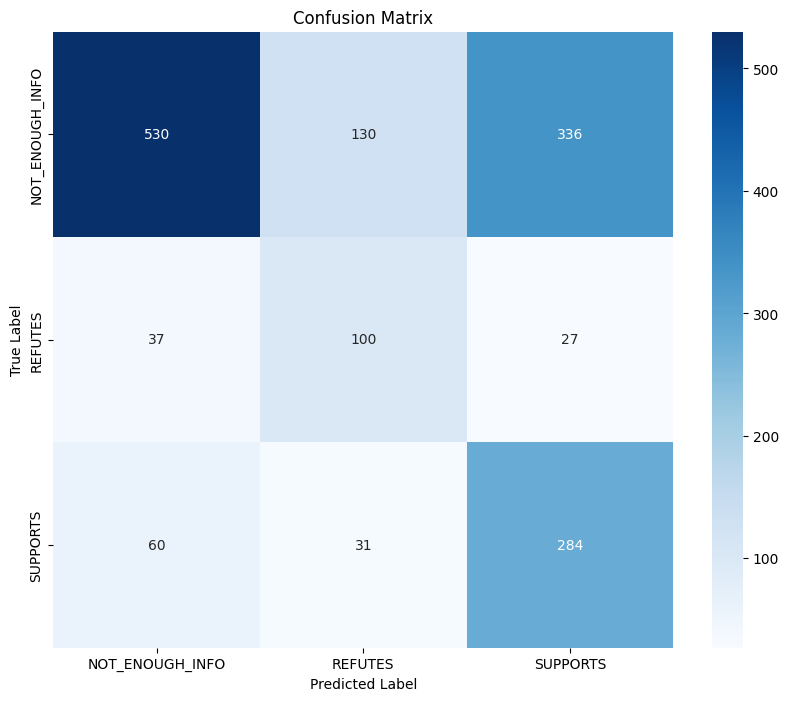

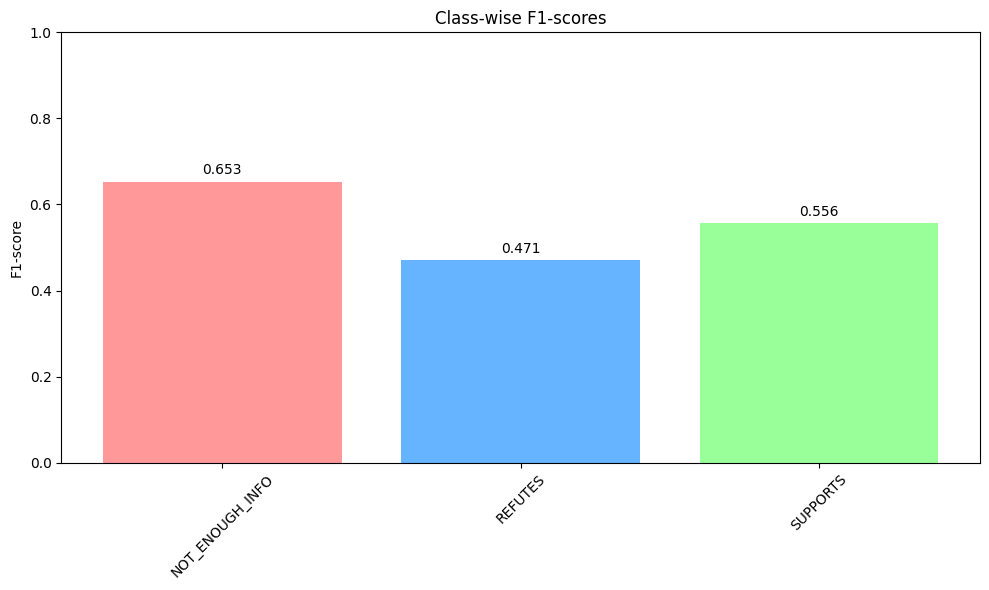

In [ ]:

label_names = sorted(train_df['claims_labels'].unique())
accuracy, f1_macro, y_pred, y_true = evaluate_model(trainer, test_dataset, label_names)



In [ ]:
print(f"\nPipeline completed!")
print(f"Final Results:")
print(f"   - Test accuracy: {accuracy:.4f}")
print(f"   - Macro F1-score: {f1_macro:.4f}")


Pipeline completed!
Final Results:
   - Test accuracy: 0.5954
   - Macro F1-score: 0.5598


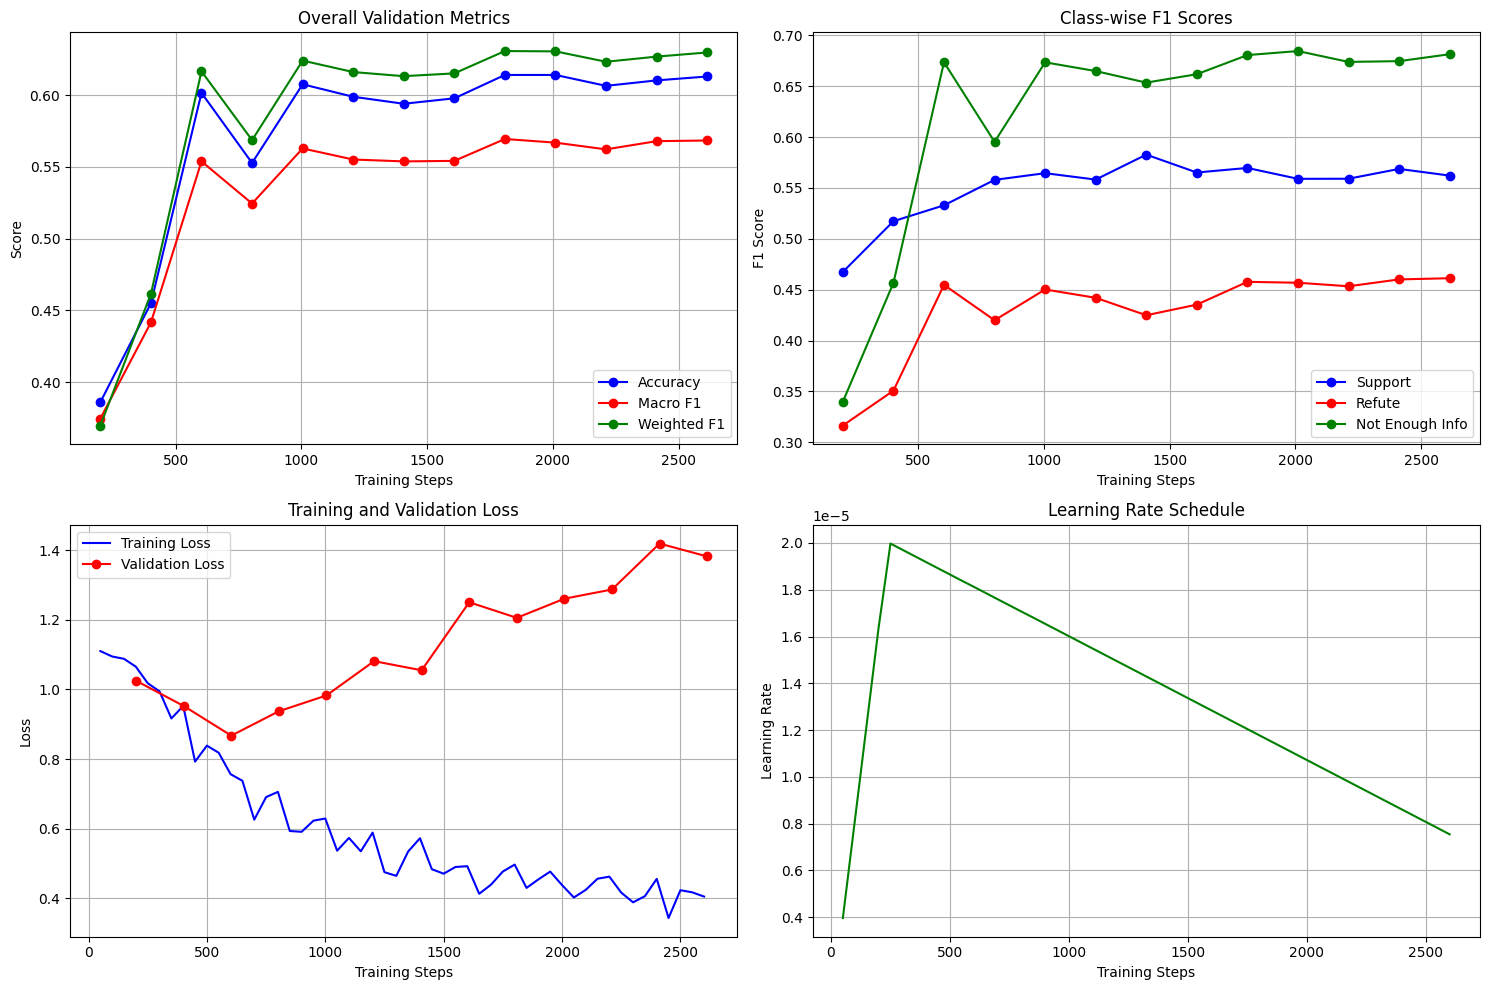

In [ ]:
plot_training_history(trainer)

In [ ]:
trainer.save_model("./final_climate_claim_classifier_v2")
tokenizer.save_pretrained("./final_climate_claim_classifier_v2")


('./final_climate_claim_classifier_v2/tokenizer_config.json',
 './final_climate_claim_classifier_v2/special_tokens_map.json',
 './final_climate_claim_classifier_v2/vocab.json',
 './final_climate_claim_classifier_v2/merges.txt',
 './final_climate_claim_classifier_v2/added_tokens.json',
 './final_climate_claim_classifier_v2/tokenizer.json')

In [ ]:
# import shutil

# shutil.make_archive("/content/final_climate_claim_classifier_v2", 'zip', "./final_climate_claim_classifier_v2")


In [ ]:
# from google.colab import files
# files.download('/content/final_climate_claim_classifier_v2.zip')




Generating groundtruth colab: https://colab.research.google.com/drive/1bSpBF9-vLyo7Zh7q_QYV0d_GWGvipZle

Pretrained ClimateBERT Full: https://huggingface.co/climatebert/distilroberta-base-climate-f

Fine tuning tutorial: https://huggingface.co/docs/transformers/training

Layer freezing: https://discuss.huggingface.co/t/freeze-lower-layers-with-auto-classification-model/11386

F1 score?: https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html